In [ ]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas
 

In [ ]:
!pip install scikit-learn

In [1]:
# Importa o tensorflow e verifica se a GPU está disponível
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-08-05 21:23:58.980746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 21:23:58.991040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 21:23:58.994195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 21:23:59.002970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 21:23:59.581865: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1722907440.162314   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722907440.177461   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722907440.177625   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
# Configurações
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_SIZE = 64

In [3]:
import string 

# Função para remover números de uma string
def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [4]:
from sklearn.decomposition import PCA

def apply_pca(images, n_components=10):
    flat_imgs = images.reshape(-1, images.shape[-1])
    pca = PCA(n_components=10)
    pca_imgs = pca.fit_transform(flat_imgs)
    return pca_imgs.reshape(images.shape[0], images.shape[1], images.shape[2], n_components)

In [5]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import string


# Sao 31 imagens diferentes onde cada uma representa um canal de cor
def load_multispectral_imagem(image_dir):
    # Pega o diretorio de uma amostra
    file_names = sorted(os.listdir(image_dir))
    # Quantidade de graos é a quantidade de imagens dividido por 31
    qtd_graos = int(len(file_names)/31)
    print(f'Quantidade de graos: {qtd_graos}')

    multispectral_imgs = []

    # Para cada grao carrega as 31 imagens e empilha elas em um array
    for i in range(qtd_graos):
        images = [np.array(Image.open(os.path.join(image_dir, file))) for file in file_names[i*31:(i+1)*31]]
        multispectral_img = np.stack(images, axis=-1)   
        multispectral_imgs.append(multispectral_img)    
    print(multispectral_imgs[0].shape)

    pca_imgs = apply_pca(np.array(multispectral_imgs), n_components=10)
    print(pca_imgs[0].shape)
    return pca_imgs

In [6]:
# Função para carregar as imagens
def process_path(image_dir, label):
    # Carrega as imagens
    images = load_multispectral_imagem(image_dir)
    # Cria um array de labels
    labels = [label]*len(images)
    # Retorna as imagens e os labels em um dataset do tensorflow
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Converte as imagens para uint8 e os labels para int32
    # uint8 é um tipo de dado que armazena inteiros de 0 a 255
    # int32 é um tipo de dado que armazena inteiros de -2^31 a 2^31-1
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint8), tf.cast(y, tf.int32)))

    # Separa o dataset em batches
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [7]:
folder_to_label = {}
id_to_label = {}

# Carrega as pastas
folders = sorted(os.listdir('_recortado'))

i = -1
for folder in folders:
    # Pega as pastas das amostras remove o numero e temos um cateogria
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))
    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i

for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

# No total sao 5 categorias e criamos dois objetos 
# Um que sai do id para o label e outro que sai do label para o id

print(folder_to_label)
print(id_to_label)
    
 

{'bandinhas1': 0, 'bandinhas2': 0, 'bandinhas3': 0, 'bandinhas4': 0, 'bandinhas5': 0, 'fermentados1': 1, 'fermentados2': 1, 'fermentados3': 1, 'fermentados4': 1, 'fermentados5': 1, 'mofados1': 2, 'mofados2': 2, 'mofados3': 2, 'mofados4': 2, 'mofados5': 2, 'queimados1': 3, 'queimados2': 3, 'queimados3': 3, 'queimados4': 3, 'queimados5': 3, 'soja1': 4, 'soja2': 4, 'soja3': 4, 'soja4': 4, 'soja5': 4}
{0: 'bandinhas', 1: 'fermentados', 2: 'mofados', 3: 'queimados', 4: 'soja'}


In [8]:
# Função para criar o dataset
def create_dataset(base_dir, folder_to_label):
    all_datasets = []

    # Para cada pasta, carrega as imagens e os labels 
    # Adiciona o dataset na lista de datasets
    for folder_name, label in folder_to_label.items():
        class_dir = os.path.join(base_dir, folder_name)
        dataset = process_path(class_dir, label)
        all_datasets.append(dataset)
    
    # Mescla todos os datasets em um único dataset
    dataset = all_datasets[0]
    for ds in all_datasets[1:]:
        dataset = dataset.concatenate(ds)

    return dataset

# Chama a função para criar o dataset
dataset = create_dataset('_recortado', folder_to_label=folder_to_label)

Quantidade de graos: 158
(64, 64, 31)
(64, 64, 10)


I0000 00:00:1722907449.926447   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722907449.926668   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722907449.926840   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722907449.994619   16752 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Quantidade de graos: 145
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 160
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 160
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 217
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 92
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 112
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 115
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 142
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 113
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 56
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 55
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 56
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 53
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 54
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 130
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 121
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 127
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 123
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 117
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 265
(64, 64, 31)

In [9]:
len(dataset)


106

In [10]:
# funcao que mostra todos batch de imagens do dataset
def preview_dataset(dataset):    
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')
        
        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)    
            print(id_to_label[label.numpy() ])

            plt.figure(figsize=(64,64))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(1,31,i+1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()

#preview_dataset(dataset)

In [11]:
# Funcao para separar o dataset em treino, validacao e teste e embaralhar
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)
    train_size = int(total_size * train_split)
    validation_size = int(total_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)

    val_ds = remaining_ds.take(validation_size)
    test_ds = remaining_ds.skip(validation_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f'Quantidade de imagens de treino: {len(train_ds)}')
print(f'Quantidade de imagens de validação: {len(val_ds)}')
print(f'Quantidade de imagens de teste: {len(test_ds)}')

# Cache: Mantém as imagens na memória após serem carregadas do disco
# Shuffle: Mistura as imagens de treino
# Prefetch: Carrega as imagens para a GPU enquanto a GPU está ocupada
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Quantidade de imagens de treino: 84
Quantidade de imagens de validação: 10
Quantidade de imagens de teste: 12


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 10), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
# altera o tamanho da imagem e normaliza os valores
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# aumenta a quantidade de imagens no dataset atraves de flip e rotacao
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31) 
n_classes = len(id_to_label)
print(n_classes)


5


In [14]:
# visualizacao dos tensores
for data, label in train_ds.take(10):
    print(data.shape, label)

(31, 64, 64, 10) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(31,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([4 4 4 4 4 4 4 

2024-08-05 21:24:44.941675: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   
LAYER_SIZE = 10 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, LAYER_SIZE)

# Cria o modelo de rede neural convolucional
# Aplicando camadas de convolução, pooling e densas
# Densas são camadas totalmente conectadas
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Camada de saída com softmax para n classes
])


# Compila o modelo aplicando a função de otimização, função de perda e métricas
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

##### Recortado
Com 100 épocas: 

Epoch 100/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8871 - loss: 0.2952 - val_accuracy: 0.8411 - val_loss: 0.3538


##### Recortado_bkp

Usando 5 categorias de graos obtemos:

Epoch 50/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8190 - loss: 0.4544 - val_accuracy: 0.8936 - val_loss: 0.369

Epoch 30/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2930 - loss: 1.5547 - val_accuracy: 0.3529 - val_loss: 1.6023

Bandinhas - Fermentandos - Queimados - Soja - Mofados: 76%

Bandinhas - Fermentandos - Queimados - Soja: 87%

Bandinhas - Queimados - Soja: 96%

In [21]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.3241  


[0.31215915083885193, 0.8820375204086304]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3489  

Text(0.5, 1.0, 'training and validation accuracy')

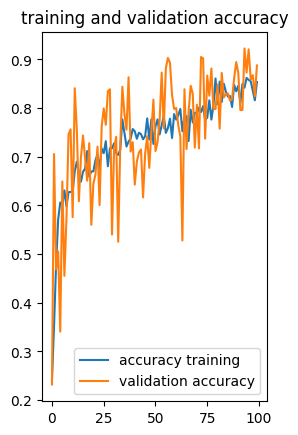

In [22]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='accuracy training')
plt.plot(range(EPOCHS), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

Text(0.5, 1.0, 'training and validation loss')

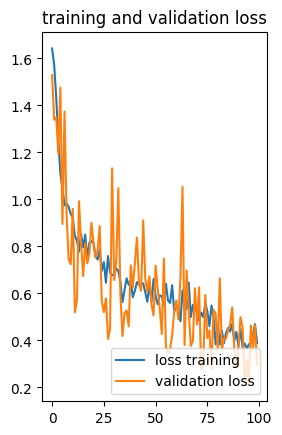

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='loss training')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='lower right')
plt.title('training and validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


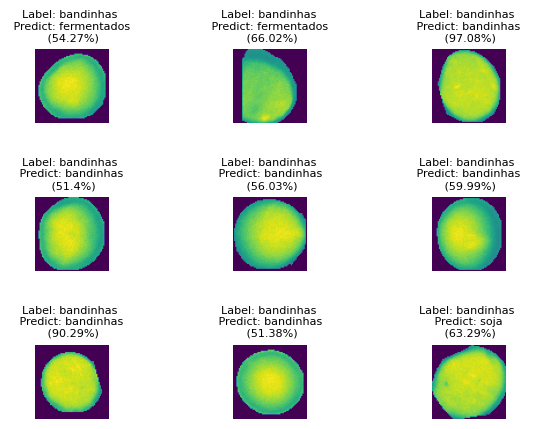

: 

In [33]:
import tensorflow as tf


for images_batch, labels_batch in test_ds.take(1):    
    for i in range(9):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]
        
        im_to_show = image[...,0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(3,3, i+ 1)
        plt.imshow(im_to_show)
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)
        
    

In [23]:
model.save(f"models/model_new{n_classes}_64.keras")